In [2]:
using CSV
using DataFrames

# Load the CSV file into a DataFrame
robot_data = CSV.read("data/robot_inverse_kinematics_dataset.csv", DataFrame)
#println(wine_data);

Row,q1,q2,q3,q4,q5,q6,x,y,z
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-1.51,-0.763,1.85,-0.817,0.912,2.32,-0.0947,0.15,0.301
2,-2.84,0.52,1.58,-1.27,-1.39,0.617,0.142,-0.1,0.225
3,-1.23,0.695,1.22,-1.13,0.0343,6.27,-0.0833,0.223,0.206
4,-1.99,1.06,1.74,-1.76,-1.24,4.76,0.135,-0.0314,0.37
5,1.05,0.836,1.34,-1.89,0.484,4.38,-0.056,-0.229,0.26
6,0.762,-0.717,1.86,1.25,0.477,6.11,-0.168,-0.0712,0.245
7,-0.0943,-1.01,1.35,2.37,-0.635,4.87,0.00422,-0.0616,0.12
8,-1.38,1.39,1.34,-2.53,0.626,3.61,-0.0954,0.235,0.355
9,2.75,-0.358,1.65,-1.48,-1.28,3.17,-0.00242,-0.15,0.209


In [3]:
include("src/qsrfe.jl")

Main.qsrfe

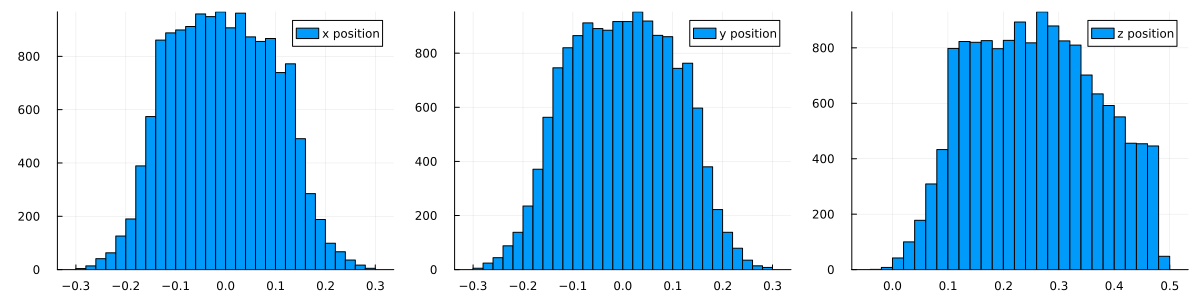

In [20]:
using Plots

# Plot histogram of the quality column
p1 = histogram(robot_data.x, xlabel="position", ylabel="Frequency", label="x position")
p2 = histogram(robot_data.y, label="y position")
p3 = histogram(robot_data.z, label="z position")
plot(p1,p2,p3,layout = (1, 3), size = (1200, 300),title="")

In [23]:
using MLJ

# Define the features and target variable
X = select(robot_data, Not(:x, :y, :z))
y = wine_data.x

# Partition the data into training (70%) and testing (30%) sets
train, test = partition(eachindex(y), 0.7, shuffle=true)

X_train = X[train, :]
y_train = y[train]
X_test = X[test, :]
y_test = y[test]
# Convert the training and testing sets into matrices and vectors
xtrain = Matrix(X_train)
ytrain = Vector(y_train)
xtest = Matrix(X_test)
ytest = Vector(y_test)


xtrain = xtrain[setdiff(1:end, indices_to_remove), :]
ytrain = ytrain[setdiff(1:end, indices_to_remove)];

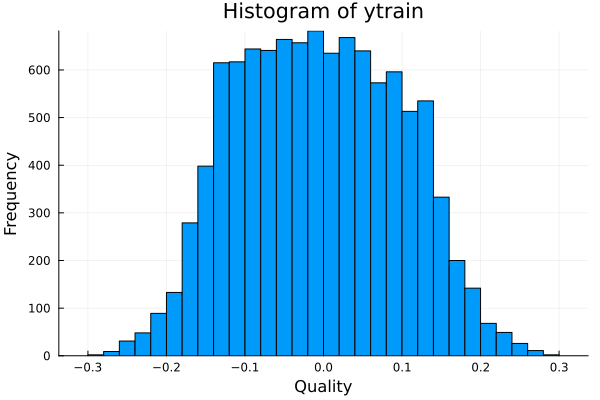

In [24]:
histogram(ytrain, title="Histogram of ytrain", xlabel="Quality", ylabel="Frequency", label="")

In [26]:
println("Size of X_train: ", size(X_train))
println("Size of y_train: ", size(y_train))
println("Size of X_test: ", size(X_test))
println("Size of y_test: ", size(y_test))

Size of X_train: (10500, 6)
Size of y_train: (10500,)
Size of X_test: (4500, 6)
Size of y_test: (4500,)


In [49]:
#test cell for hyperparameter testing
#model = model
N= 2^12
λ = 0.00000000001#srfe
#λ = 0.00004
model = qsrfe.rfeRegressor(N=N,λ=λ, σ2=1.0,intercept=true)

c = qsrfe.fit(model,xtrain,ytrain;verbose=true)
ytrainpred = qsrfe.predict(model,xtrain)
ytestpred = qsrfe.predict(model,xtest);

println("")
println("rel L2: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("rel mse: ",qsrfe.rel_mse(ytest,ytestpred)," rel train mse: ",qsrfe.rel_mse(ytrain,ytrainpred))

support: 4097/4097
rel L2: 0.04959918409818134 train rel: 0.016793824556550395
abs: 0.0029605709442184426 train abs: 0.0013477817781521618
mse: 2.567084831907889e-5 train mse: 2.9857445823698686e-6
rel mse: 0.04959918409818134 rel train mse: 0.016793824556550395


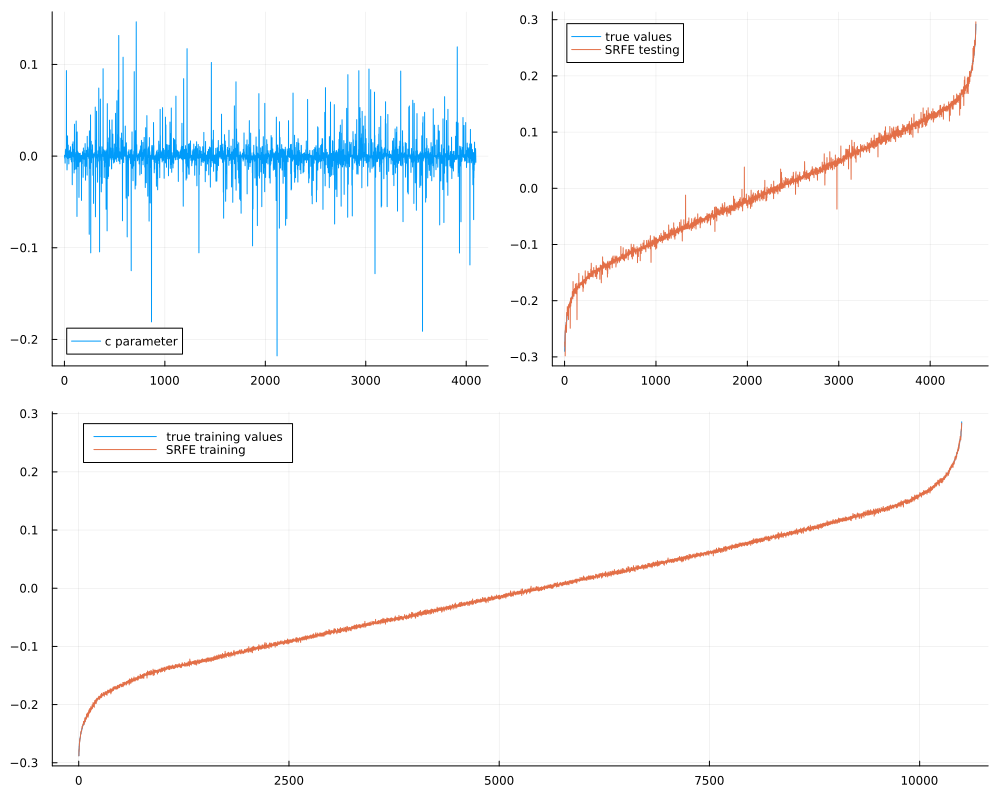

In [50]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [81]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^13,λ=λ, σ2=σ2,intercept=true)
    c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
    ytestpred = qsrfe.predict(model,xtest)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.000001..0.9),
                        σ2 = (1.0..100.0),
                        max_trials = 60 );

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 60 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 32
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 60
           max_evals: 60
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬──────────┐
│     Trial │    Value │
│        37 │          │
├───────────┼──────────┤
│         λ │ 0.661512 │
│        σ2 │      1.0 │
│    Pruned │    false │
│   Success │    false │
│ Objective │ 0.658043 │
└───────────┴──────────┘


In [82]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^13,λ=λ, σ2=σ2,intercept=true)
    c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
    ytestpred = qsrfe.predict(model,xtest)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.001..1.9),
                        σ2 = (0.01..5.0),
                        max_trials = 60 );

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 60 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 32
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 60
           max_evals: 60
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬──────────┐
│     Trial │    Value │
│        24 │          │
├───────────┼──────────┤
│         λ │ 0.761313 │
│        σ2 │ 0.142681 │
│    Pruned │    false │
│   Success │    false │
│ Objective │ 0.596474 │
└───────────┴──────────┘


In [80]:
5*60 / 5

60.0